In [ ]:
import numpy as np
import re
import pandas as pd
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.naive_bayes import MultinomialNB
from google.colab import drive
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
import spacy
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## **Data Preprocessing**

In [ ]:
# data = pd.read_csv('https://drive.google.com/file/d/17dGFQwjIviABHOh_RobPqrWfr15YpuNK/view?usp=sharing')
data = pd.read_csv('https://drive.google.com/uc?export=download&id=17dGFQwjIviABHOh_RobPqrWfr15YpuNK')
# https://drive.google.com/uc?export=download&id=FILE_ID
data.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [ ]:
data['fraudulent'].value_counts()

,count
fraudulent,
0,17014
1,866


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6333 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17879 non-null  object
 7   requirements         15184 non-null  object
 8   benefits             10668 non-null  object
 9   telecommuting        17880 non-null  int64 
 10  has_company_logo     17880 non-null  int64 
 11  has_questions        17880 non-null  int64 
 12  employment_type      14409 non-null  object
 13  required_experience  10830 non-null  object
 14  required_education   9775 non-null   object
 15  industry             12977 non-null  object
 16  func

In [ ]:
# # Simple Random Sampling
# fraudulent_0 = data[data['fraudulent'] == 0]
# fraudulent_1 = data[data['fraudulent'] == 1]

# sample_0 = fraudulent_0.sample(n=866, random_state=42)

# data = pd.concat([sample_0, fraudulent_1])

## Metode Sampling

In [ ]:
# Systematic Sampling

import pandas as pd
import numpy as np

fraudulent_0 = data[data['fraudulent'] == 0]
fraudulent_1 = data[data['fraudulent'] == 1]

sample_size = 866

def systematic_sampling(df, sample_size):
    step = len(df) // sample_size
    random_start = np.random.randint(0, step)
    return df.iloc[random_start::step].reset_index(drop=True)

sample_0 = systematic_sampling(fraudulent_0, sample_size)
sample_1 = systematic_sampling(fraudulent_1, sample_size)
data_systematic = pd.concat([sample_0, sample_1], ignore_index=True)

data_systematic = data_systematic.sample(frac=1, random_state=42).reset_index(drop=True)

print(data_systematic['fraudulent'].value_counts())
data = data_systematic.copy()

fraudulent
0    896
1    866
Name: count, dtype: int64


## Feature Selection

In [ ]:
data.isnull().sum()

,0
job_id,0
title,0
location,42
department,1118
salary_range,1409
company_profile,723
description,1
requirements,276
benefits,742
telecommuting,0


In [ ]:
data['fraudulent'].value_counts()

,count
fraudulent,
0,896
1,866


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1762 entries, 0 to 1761
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               1762 non-null   int64 
 1   title                1762 non-null   object
 2   location             1720 non-null   object
 3   department           644 non-null    object
 4   salary_range         353 non-null    object
 5   company_profile      1039 non-null   object
 6   description          1761 non-null   object
 7   requirements         1486 non-null   object
 8   benefits             1020 non-null   object
 9   telecommuting        1762 non-null   int64 
 10  has_company_logo     1762 non-null   int64 
 11  has_questions        1762 non-null   int64 
 12  employment_type      1330 non-null   object
 13  required_experience  957 non-null    object
 14  required_education   891 non-null    object
 15  industry             1224 non-null   object
 16  functi

<BarContainer object of 2 artists>

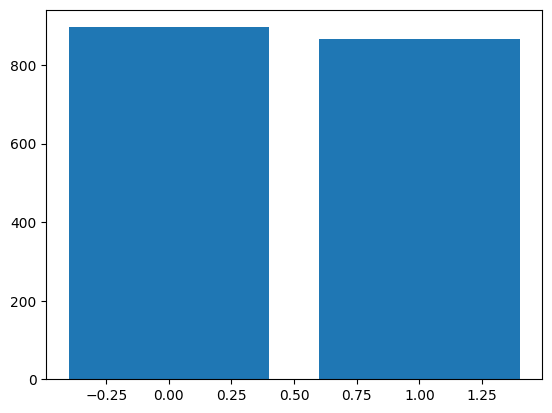

In [ ]:
distribution = data['fraudulent'].value_counts()
plt.bar(distribution.index,distribution.values)

0: real job \\
1: fake job

In [ ]:
data.isnull().sum()

,0
job_id,0
title,0
location,42
department,1118
salary_range,1409
company_profile,723
description,1
requirements,276
benefits,742
telecommuting,0


In [ ]:
# For text columns, replace missing values with an empty string
text_columns = ['title', 'company_profile', 'description', 'requirements', 'benefits',
                'industry','location','function','employment_type']
data[text_columns] = data[text_columns].fillna(' ')

In [ ]:
# Fungsi untuk menghitung mean dari TF-IDF tiap sel
def calculate_tfidf_mean(column):
    tfidf = TfidfVectorizer()
    tfidf_matrix = tfidf.fit_transform(column).toarray()
    tfidf_mean = tfidf_matrix.mean(axis=1)
    return tfidf_mean

# Dataframe baru untuk menyimpan hasil
tfidf_mean_df = pd.DataFrame()
# Menghitung mean TF-IDF untuk setiap kolom dan menyimpan hasilnya ke dataframe baru
for i in text_columns:
    tfidf_mean_df[i + '_numeric'] = calculate_tfidf_mean(data[i])

# # Menghitung matriks korelasi
correlation_matrix = tfidf_mean_df.corr()
correlation_matrix['function_numeric']
# correlation_matrix.abs().mean()
# print(correlation_matrix)

,function_numeric
title_numeric,-0.117768
company_profile_numeric,0.251125
description_numeric,0.131212
requirements_numeric,0.302906
benefits_numeric,0.169626
industry_numeric,0.570503
location_numeric,0.172203
function_numeric,1.000000
employment_type_numeric,0.555108


In [ ]:
data

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,2380,Administrative Assistant/Receptionist,"US, FL, MIAMI",NaN,1000-1000,,Professionally and courteously answers incomin...,Minimum qualifications:High School Diploma or ...,Compensation/benefits package includes:Compreh...,0,0,0,Full-time,Entry level,High School or equivalent,Consumer Services,Accounting/Auditing,1
1,4167,Customer Service Associate - On Call,"US, NY, New York",NaN,NaN,"Novitex Enterprise Solutions, formerly Pitney ...",The Customer Service Associate will be based i...,Minimum Requirements:Minimum of 6 months custo...,,0,1,0,Part-time,Entry level,High School or equivalent,Banking,Customer Service,0
2,8292,Senior Back-End Developer,"SE, AB, Stockholm",NaN,NaN,,"Wiget Media is an online advertising network, ...","Extremely competent with HTML, CSS, JavaScript...",Competitive salaryHardware of choiceFriendly o...,0,0,1,Full-time,Mid-Senior level,Professional,Online Media,Engineering,0
3,13377,Senior Software Engineer,"IE, L, Dublin 2",IT,NaN,We are an ambitious company looking for energe...,Lead and mentor fellow EngineersMaintain exper...,Substantial relevant experience Bachelor’s deg...,,0,1,0,Full-time,Mid-Senior level,NaN,Information Technology and Services,Engineering,0
4,17808,Remote Data Entry Rep Needed,"US, AL, Birmingham",NaN,30000-35000,,We're looking for self-motivated individuals w...,Must be able to work from home,,0,1,0,Full-time,Entry level,High School or equivalent,Consumer Services,Customer Service,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1757,5688,Network Marketing,"US, TX,",NaN,7200-1380000,,"Are you looking to make anywhere from 600-115,...","An ambition to succeed, A desire to be the bes...","Residual Income, Travel dollars, Car Dollars, ...",0,0,0,Full-time,Not Applicable,Unspecified,Marketing and Advertising,Advertising,1
1758,8592,Med Surg RN,"US, TX, San Antonio",NaN,NaN,,Find more jobs at #URL_1efb08d6a6da1c56afb2d0c...,,,0,0,0,Full-time,NaN,NaN,Hospital & Health Care,,1
1759,16881,Customer Service Positions ($18-$22 an hour),"US, OH, Cincinnati",NaN,NaN,"LEI Home Enhancements, is an Ohio based compan...",LEI Home Enhancements is hiring for ENTRY LEVE...,Who We're Looking For: You must possess great ...,We Offer: Weekly Base plus commissions (approx...,0,1,0,,NaN,NaN,Consumer Goods,Customer Service,0
1760,17530,Receptionist/Office Clerk,"US, GA, ATLANTA",NaN,NaN,,Experienced professional Receptionist with det...,,,0,0,0,Full-time,Entry level,High School or equivalent,Accounting,Administrative,1


In [ ]:
from scipy.stats import pointbiserialr, pearsonr
for i in list(tfidf_mean_df.columns):
  point_biserial_corr, p_value = pointbiserialr(tfidf_mean_df[i], data['fraudulent'])
  print('Korelasi Point-Biserial antara '+i+' dan fraudulent: ', point_biserial_corr)

Korelasi Point-Biserial antara title_numeric dan fraudulent:  0.09666023743656015
Korelasi Point-Biserial antara company_profile_numeric dan fraudulent:  -0.4837748390504538
Korelasi Point-Biserial antara description_numeric dan fraudulent:  -0.0567021770767491
Korelasi Point-Biserial antara requirements_numeric dan fraudulent:  -0.17596658333386572
Korelasi Point-Biserial antara benefits_numeric dan fraudulent:  -0.0032291454092456626
Korelasi Point-Biserial antara industry_numeric dan fraudulent:  -0.03282022545536621
Korelasi Point-Biserial antara location_numeric dan fraudulent:  -0.026955040268191954
Korelasi Point-Biserial antara function_numeric dan fraudulent:  -0.03241784149753704
Korelasi Point-Biserial antara employment_type_numeric dan fraudulent:  -0.0637381658820746


In [ ]:
selectedfeatures = ['title', 'company_profile', 'description', 'requirements', 'benefits', 'industry', 'employment_type', 'location']
data['merge_text'] = ''
for i in selectedfeatures:
  data['merge_text'] = data['merge_text']+data[i]

data.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,merge_text
0,2380,Administrative Assistant/Receptionist,"US, FL, MIAMI",NaN,1000-1000,,Professionally and courteously answers incomin...,Minimum qualifications:High School Diploma or ...,Compensation/benefits package includes:Compreh...,0,0,0,Full-time,Entry level,High School or equivalent,Consumer Services,Accounting/Auditing,1,Administrative Assistant/Receptionist Profess...
1,4167,Customer Service Associate - On Call,"US, NY, New York",NaN,NaN,"Novitex Enterprise Solutions, formerly Pitney ...",The Customer Service Associate will be based i...,Minimum Requirements:Minimum of 6 months custo...,,0,1,0,Part-time,Entry level,High School or equivalent,Banking,Customer Service,0,Customer Service Associate - On Call Novitex E...
2,8292,Senior Back-End Developer,"SE, AB, Stockholm",NaN,NaN,,"Wiget Media is an online advertising network, ...","Extremely competent with HTML, CSS, JavaScript...",Competitive salaryHardware of choiceFriendly o...,0,0,1,Full-time,Mid-Senior level,Professional,Online Media,Engineering,0,Senior Back-End Developer Wiget Media is an on...
3,13377,Senior Software Engineer,"IE, L, Dublin 2",IT,NaN,We are an ambitious company looking for energe...,Lead and mentor fellow EngineersMaintain exper...,Substantial relevant experience Bachelor’s deg...,,0,1,0,Full-time,Mid-Senior level,NaN,Information Technology and Services,Engineering,0,Senior Software EngineerWe are an ambitious co...
4,17808,Remote Data Entry Rep Needed,"US, AL, Birmingham",NaN,30000-35000,,We're looking for self-motivated individuals w...,Must be able to work from home,,0,1,0,Full-time,Entry level,High School or equivalent,Consumer Services,Customer Service,1,Remote Data Entry Rep Needed We're looking for...


In [ ]:
data['fraudulent'] = data['fraudulent'].replace({0: 'real', 1: 'fake'})

In [ ]:
data['fraudulent'].value_counts()

,count
fraudulent,
real,896
fake,866


## Naive Bayes

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
port_stem = PorterStemmer()

In [ ]:
pattern = re.compile('[^a-zA-Z]')
def stemming(content):
    stemmed_content = pattern.sub(' ', content).lower().split()
    stopwords_set = set(stopwords.words('english'))
    stemmed_content = ' '.join(word for word in stemmed_content if word not in stopwords_set)
    return stemmed_content

In [ ]:
data['merge_text'] = data['merge_text'].apply(stemming)

In [ ]:
X = data['merge_text'].values
Y = data['fraudulent'].values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

In [ ]:
vectorizer = TfidfVectorizer()
X_train_transformed = vectorizer.fit_transform(X_train)
X_test_transformed = vectorizer.transform(X_test)

In [ ]:
vectorizer_limited = TfidfVectorizer(max_features=7000)
X_train_transformed_limited = vectorizer_limited.fit_transform(X_train)
X_test_transformed_limited = vectorizer_limited.transform(X_test)

In [ ]:
X_train_transformed.shape[1]

20375

In [ ]:
X_train_transformed_limited.shape

(1233, 7000)

In [ ]:
count = CountVectorizer()
Xcount_train_transformed = count.fit_transform(X_train)
Xcount_test_transformed = count.transform(X_test)

In [ ]:
count_ngr = CountVectorizer(ngram_range=(2,2))
Xcount_train_transformed_ngr = count_ngr.fit_transform(X_train)
Xcount_test_transformed_ngr = count_ngr.transform(X_test)

In [ ]:
nb_classifier = MultinomialNB()

In [ ]:
# Default tf idf

nb_classifier.fit(X_train_transformed, y_train)

# Predict on the test set
y_pred = nb_classifier.predict(X_test_transformed)

# Print the accuracy and classification report
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Classification Report:\n{classification_report(y_test, y_pred)}")

Accuracy: 0.9017013232514177
Classification Report:
              precision    recall  f1-score   support

        fake       0.90      0.90      0.90       259
        real       0.90      0.91      0.90       270

    accuracy                           0.90       529
   macro avg       0.90      0.90      0.90       529
weighted avg       0.90      0.90      0.90       529



In [ ]:
# Limited tf idf

max = 0.5

for i in range(5,100,5):
  vectorizer_limited = TfidfVectorizer(max_features=int(i/100*X_train_transformed.shape[1]//1))
  X_train_transformed_limited = vectorizer_limited.fit_transform(X_train)
  X_test_transformed_limited = vectorizer_limited.transform(X_test)

  nb_classifier.fit(X_train_transformed_limited, y_train)

  # Predict on the test set
  y_pred = nb_classifier.predict(X_test_transformed_limited)
  report = classification_report(y_test, y_pred, output_dict=True)
  if report['fake']['recall'] > max:
    max = report['fake']['recall']
    features = i/100*X_train_transformed.shape[1]
    pred_opt = y_pred
    maxf = int(i/100*X_train_transformed.shape[1]//1)

# Print the accuracy and classification report
print(f"Accuracy: {accuracy_score(y_test, pred_opt)}")
print(f"Classification Report:\n{classification_report(y_test, pred_opt)}")
print(maxf)

Accuracy: 0.8979206049149339
Classification Report:
              precision    recall  f1-score   support

        fake       0.89      0.90      0.90       259
        real       0.90      0.90      0.90       270

    accuracy                           0.90       529
   macro avg       0.90      0.90      0.90       529
weighted avg       0.90      0.90      0.90       529

5093


In [ ]:
print(max)

0.8996138996138996


In [ ]:
# bag of words (count default)

nb_classifier.fit(Xcount_train_transformed, y_train)

# Predict on the test set
y_pred = nb_classifier.predict(Xcount_test_transformed)

# Print the accuracy and classification report
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Classification Report:\n{classification_report(y_test, y_pred)}")

Accuracy: 0.8941398865784499
Classification Report:
              precision    recall  f1-score   support

        fake       0.89      0.89      0.89       259
        real       0.89      0.90      0.90       270

    accuracy                           0.89       529
   macro avg       0.89      0.89      0.89       529
weighted avg       0.89      0.89      0.89       529



In [ ]:
# bag of words (n gram)

nb_classifier.fit(Xcount_train_transformed_ngr, y_train)

# Predict on the test set
y_pred = nb_classifier.predict(Xcount_test_transformed_ngr)

# Print the accuracy and classification report
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Classification Report:\n{classification_report(y_test, y_pred)}")

Accuracy: 0.9300567107750473
Classification Report:
              precision    recall  f1-score   support

        fake       0.94      0.92      0.93       259
        real       0.92      0.94      0.93       270

    accuracy                           0.93       529
   macro avg       0.93      0.93      0.93       529
weighted avg       0.93      0.93      0.93       529



## Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
LR_classifier = LogisticRegression()

In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, classification_report, log_loss
import matplotlib.pyplot as plt

# Siapkan list untuk simpan log loss per iterasi
log_losses_sgd = []

# Logistic Regression pakai SGD
SGD_LR_classifier = SGDClassifier(loss='log_loss', learning_rate='constant', eta0=0.01, max_iter=1, warm_start=True, random_state=42)

# Iterasi training manual
for i in range(200):
    SGD_LR_classifier.fit(X_train_transformed, y_train)
    y_train_proba = SGD_LR_classifier.predict_proba(X_train_transformed)
    loss = log_loss(y_train, y_train_proba)
    log_losses_sgd.append(loss)

# Predict di test set setelah training selesai
y_pred_sgd = SGD_LR_classifier.predict(X_test_transformed)

# Print akurasi & classification report
print(f"Accuracy: {accuracy_score(y_test, y_pred_sgd)}")
print(f"Classification Report:\n{classification_report(y_test, y_pred_sgd)}")

# # Plot log loss curve
# plt.plot(log_losses_sgd, marker='o')
# plt.xlabel('Iterasi')
# plt.ylabel('Log Loss (Train)')
# plt.title('Log Loss Curve Logistic Regression (SGD)')
# plt.grid(True)
# plt.show()


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_stochastic

Accuracy: 0.9168241965973535
Classification Report:
              precision    recall  f1-score   support

        fake       0.94      0.89      0.91       259
        real       0.90      0.94      0.92       270

    accuracy                           0.92       529
   macro avg       0.92      0.92      0.92       529
weighted avg       0.92      0.92      0.92       529



/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_stochastic

In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss, accuracy_score, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import matplotlib.pyplot as plt

# Siapkan parameter awal
max_recall = 0.5
maxf = 0
features = 0
pred_opt = None
optimal_log_losses = []

# Looping proporsi fitur TF-IDF
for i in range(5, 100, 5):
    max_features_current = int(i/100 * X_train_transformed.shape[1])
    vectorizer_limited = TfidfVectorizer(max_features=max_features_current)
    X_train_transformed_limited = vectorizer_limited.fit_transform(X_train)
    X_test_transformed_limited = vectorizer_limited.transform(X_test)

    # Inisialisasi SGD Logistic Regression
    SGD_LR_classifier = SGDClassifier(loss='log_loss', learning_rate='constant', eta0=0.01, max_iter=1, warm_start=True, random_state=42)

    # Simpan log loss sementara untuk proporsi ini
    temp_log_losses = []

    for epoch in range(100):
        SGD_LR_classifier.fit(X_train_transformed_limited, y_train)

        # Predict probability di training set
        y_train_proba = SGD_LR_classifier.predict_proba(X_train_transformed_limited)

        # Hitung log loss train
        loss = log_loss(y_train, y_train_proba)
        temp_log_losses.append(loss)

    # Predict di test set setelah selesai
    y_pred = SGD_LR_classifier.predict(X_test_transformed_limited)
    report = classification_report(y_test, y_pred, output_dict=True)

    # Kalau recall-nya lebih bagus → simpan hasil & log loss-nya
    if report['fake']['recall'] > max_recall:
        max_recall = report['fake']['recall']
        features = max_features_current
        pred_opt = y_pred
        maxf = i/100
        optimal_log_losses = temp_log_losses  # simpan loss-nya

# Print hasil optimal
print(f"Accuracy: {accuracy_score(y_test, pred_opt)}")
print(f"Classification Report:\n{classification_report(y_test, pred_opt)}")
print(f"Proporsi Fitur Terbaik: {maxf*100:.0f}% ({features} fitur)")

# Plot log loss curve untuk proporsi optimal saja
# plt.figure(figsize=(8, 5))
# plt.plot(optimal_log_losses, marker='o')
# plt.xlabel('Epoch')
# plt.ylabel('Log Loss (Train)')
# plt.title(f'Log Loss Curve (TF-IDF {maxf*100:.0f}% Fitur)')
# plt.grid(True)
# plt.show()


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_stochastic

Accuracy: 0.9092627599243857
Classification Report:
              precision    recall  f1-score   support

        fake       0.93      0.88      0.90       259
        real       0.89      0.94      0.91       270

    accuracy                           0.91       529
   macro avg       0.91      0.91      0.91       529
weighted avg       0.91      0.91      0.91       529

Proporsi Fitur Terbaik: 30% (6112 fitur)


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, classification_report, log_loss
import matplotlib.pyplot as plt

# Siapkan list untuk simpan log loss per iterasi
log_losses_sgd = []

# Logistic Regression pakai SGD
SGD_LR_classifier = SGDClassifier(loss='log_loss', learning_rate='constant', eta0=0.01, max_iter=1, warm_start=True, random_state=42)

# Iterasi training manual
for i in range(100):
    SGD_LR_classifier.fit(Xcount_train_transformed, y_train)
    y_train_proba = SGD_LR_classifier.predict_proba(Xcount_train_transformed)
    loss = log_loss(y_train, y_train_proba)
    log_losses_sgd.append(loss)

# Predict di test set setelah training selesai
y_pred_sgd = SGD_LR_classifier.predict(Xcount_test_transformed)

# Print akurasi & classification report
print(f"Accuracy: {accuracy_score(y_test, y_pred_sgd)}")
print(f"Classification Report:\n{classification_report(y_test, y_pred_sgd)}")

# # Plot log loss curve
# plt.plot(log_losses_sgd, marker='o')
# plt.xlabel('Iterasi')
# plt.ylabel('Log Loss (Train)')
# plt.title('Log Loss Curve Logistic Regression (SGD)')
# plt.grid(True)
# plt.show()


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_stochastic

Accuracy: 0.9224952741020794
Classification Report:
              precision    recall  f1-score   support

        fake       0.92      0.92      0.92       259
        real       0.93      0.92      0.92       270

    accuracy                           0.92       529
   macro avg       0.92      0.92      0.92       529
weighted avg       0.92      0.92      0.92       529



/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_stochastic

Accuracy: 0.9262759924385633
Classification Report:
              precision    recall  f1-score   support

        fake       0.94      0.91      0.92       259
        real       0.92      0.94      0.93       270

    accuracy                           0.93       529
   macro avg       0.93      0.93      0.93       529
weighted avg       0.93      0.93      0.93       529



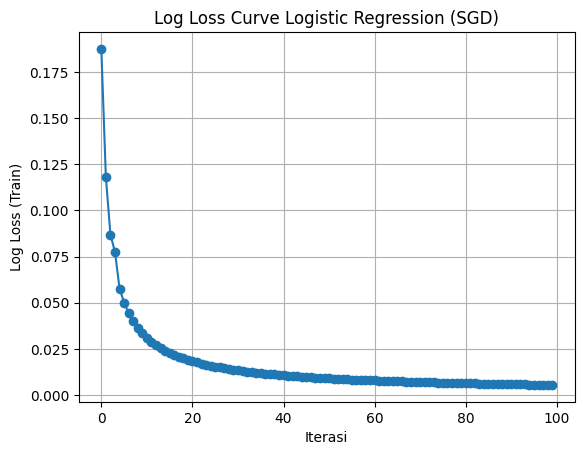

In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, classification_report, log_loss
import matplotlib.pyplot as plt

# Siapkan list untuk simpan log loss per iterasi
log_losses_sgd = []

# Logistic Regression pakai SGD
SGD_LR_classifier = SGDClassifier(loss='log_loss', learning_rate='constant', eta0=0.01, max_iter=1, warm_start=True, random_state=42)

# Iterasi training manual
for i in range(100):
    SGD_LR_classifier.fit(Xcount_train_transformed_ngr, y_train)
    y_train_proba = SGD_LR_classifier.predict_proba(Xcount_train_transformed_ngr)
    loss = log_loss(y_train, y_train_proba)
    log_losses_sgd.append(loss)

# Predict di test set setelah training selesai
y_pred_sgd = SGD_LR_classifier.predict(Xcount_test_transformed_ngr)

# Print akurasi & classification report
print(f"Accuracy: {accuracy_score(y_test, y_pred_sgd)}")
print(f"Classification Report:\n{classification_report(y_test, y_pred_sgd)}")

# Plot log loss curve
plt.plot(log_losses_sgd, marker='o')
plt.xlabel('Iterasi')
plt.ylabel('Log Loss (Train)')
plt.title('Log Loss Curve Logistic Regression (SGD)')
plt.grid(True)
plt.show()


## Support Vector Machine

In [ ]:
# TF IDF Default
from sklearn.svm import SVC

svc=SVC()
svc.fit(X_train_transformed, y_train)

# Prediksi
y_pred=svc.predict(X_test_transformed)

# Menghitung akurasi dan metrik evaluasi
print('Accuracy Score: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))
print(f"Classification Report:\n{classification_report(y_test, y_pred)}")

Accuracy Score: 0.9093
Classification Report:
              precision    recall  f1-score   support

        fake       0.95      0.86      0.90       259
        real       0.88      0.95      0.91       270

    accuracy                           0.91       529
   macro avg       0.91      0.91      0.91       529
weighted avg       0.91      0.91      0.91       529



Accuracy Score: 0.9263
Classification Report:
              precision    recall  f1-score   support

        fake       0.94      0.90      0.92       259
        real       0.91      0.95      0.93       270

    accuracy                           0.93       529
   macro avg       0.93      0.93      0.93       529
weighted avg       0.93      0.93      0.93       529



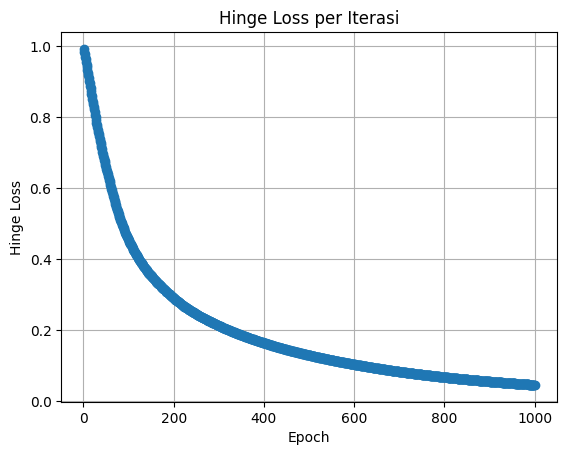

In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, classification_report, hinge_loss
import matplotlib.pyplot as plt
import numpy as np

# Inisialisasi model SVM dengan SGD
svm_iter = SGDClassifier(loss='hinge', learning_rate='constant', eta0=0.001, max_iter=1, warm_start=True, random_state=42)

# Track loss
loss_history = []
epochs = 1000

# Partial fit butuh tau dulu kelasnya
classes = np.unique(y_train)

for epoch in range(epochs):
    # Training 1 iterasi
    svm_iter.partial_fit(X_train_transformed, y_train, classes=classes)

    # Predict decision function (jarak ke hyperplane)
    decision_values = svm_iter.decision_function(X_train_transformed)

    # Hitung hinge loss
    loss = hinge_loss(y_train, decision_values)
    loss_history.append(loss)

# Prediksi hasil akhir
y_pred_iter = svm_iter.predict(X_test_transformed)

# Evaluasi
print('Accuracy Score: {0:0.4f}'.format(accuracy_score(y_test, y_pred_iter)))
print(f"Classification Report:\n{classification_report(y_test, y_pred_iter)}")

# Plot loss per iterasi
plt.plot(range(1, epochs+1), loss_history, marker='o')
plt.title('Hinge Loss per Iterasi')
plt.xlabel('Epoch')
plt.ylabel('Hinge Loss')
plt.grid(True)
plt.show()


In [ ]:
# TF IDF Limited
from sklearn.svm import SVC

# Limited tf idf
# Train the model
max = 0.5

for i in range(5,100,5):
  vectorizer_limited = TfidfVectorizer(max_features=int(i/100*X_train_transformed.shape[1]//1))
  X_train_transformed_limited = vectorizer_limited.fit_transform(X_train)
  X_test_transformed_limited = vectorizer_limited.transform(X_test)

  svc.fit(X_train_transformed_limited, y_train)

  # Predict on the test set
  y_pred = svc.predict(X_test_transformed_limited)
  report = classification_report(y_test, y_pred, output_dict=True)
  if report['fake']['recall'] > max:
    max = report['fake']['recall']
    features = i/100*X_train_transformed.shape[1]
    pred_opt = y_pred
    maxf = i/100

# Print the accuracy and classification report
print(f"Accuracy: {accuracy_score(y_test, pred_opt)}")
print(f"Classification Report:\n{classification_report(y_test, pred_opt)}")
print(maxf)

Accuracy: 0.9111531190926276
Classification Report:
              precision    recall  f1-score   support

        fake       0.92      0.90      0.91       259
        real       0.90      0.93      0.91       270

    accuracy                           0.91       529
   macro avg       0.91      0.91      0.91       529
weighted avg       0.91      0.91      0.91       529

0.05


Optimal TF-IDF feature percentage: 20%
Accuracy: 0.9224952741020794
Classification Report:
              precision    recall  f1-score   support

        fake       0.93      0.91      0.92       259
        real       0.91      0.94      0.93       270

    accuracy                           0.92       529
   macro avg       0.92      0.92      0.92       529
weighted avg       0.92      0.92      0.92       529



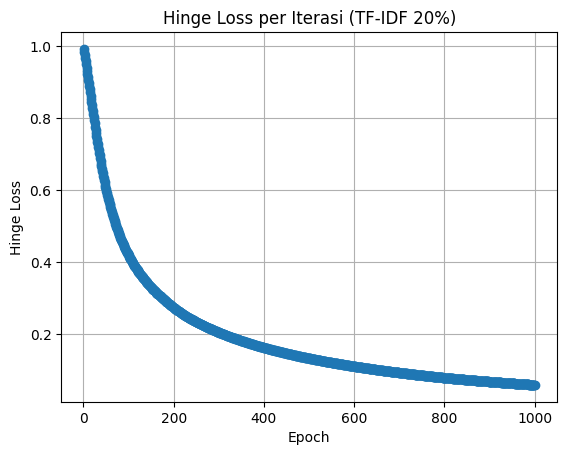

In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, hinge_loss
import matplotlib.pyplot as plt
import numpy as np

max_recall = 0.5  # awal
optimal_percentage = 0
optimal_loss_history = []
epochs = 1000

for i in range(5, 100, 5):
    # TF-IDF Limited
    vectorizer_limited = TfidfVectorizer(max_features=int(i/100 * X_train_transformed.shape[1]))
    X_train_limited = vectorizer_limited.fit_transform(X_train)
    X_test_limited = vectorizer_limited.transform(X_test)

    # Inisialisasi ulang model tiap loop
    svm_iter = SGDClassifier(loss='hinge', learning_rate='constant', eta0=0.001,
                             max_iter=1, warm_start=True, random_state=42)

    # Track loss
    loss_history = []
    classes = np.unique(y_train)

    for epoch in range(epochs):
        svm_iter.partial_fit(X_train_limited, y_train, classes=classes)
        decision_values = svm_iter.decision_function(X_train_limited)
        loss = hinge_loss(y_train, decision_values)
        loss_history.append(loss)

    # Prediksi
    y_pred = svm_iter.predict(X_test_limited)
    report = classification_report(y_test, y_pred, output_dict=True)

    # Cek recall 'fake'
    if report['fake']['recall'] > max_recall:
        max_recall = report['fake']['recall']
        optimal_percentage = i
        optimal_loss_history = loss_history.copy()
        pred_optimal = y_pred

# Tampilkan hasil optimal
print(f"Optimal TF-IDF feature percentage: {optimal_percentage}%")
print(f"Accuracy: {accuracy_score(y_test, pred_optimal)}")
print(f"Classification Report:\n{classification_report(y_test, pred_optimal)}")

# Plot loss di setting optimal
plt.plot(range(1, epochs+1), optimal_loss_history, marker='o')
plt.title(f'Hinge Loss per Iterasi (TF-IDF {optimal_percentage}%)')
plt.xlabel('Epoch')
plt.ylabel('Hinge Loss')
plt.grid(True)
plt.show()


In [ ]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler with with_mean=False
scaler = StandardScaler(with_mean=False)

# Scale the training and test data
X_train_scaled = scaler.fit_transform(Xcount_train_transformed)
X_test_scaled = scaler.transform(Xcount_test_transformed)


In [ ]:
# bag of words Default
from sklearn.svm import SVC

svc=SVC()
svc.fit(X_train_scaled, y_train)

# Prediksi
y_pred=svc.predict(X_test_scaled)

# Menghitung akurasi dan metrik evaluasi
print('Accuracy Score: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))
print(f"Classification Report:\n{classification_report(y_test, y_pred)}")

Accuracy Score: 0.8053
Classification Report:
              precision    recall  f1-score   support

        fake       0.77      0.86      0.81       259
        real       0.85      0.75      0.80       270

    accuracy                           0.81       529
   macro avg       0.81      0.81      0.80       529
weighted avg       0.81      0.81      0.80       529



In [ ]:
# bag of words Default
from sklearn.svm import SVC

svc=SVC()
svc.fit(Xcount_train_transformed, y_train)

# Prediksi
y_pred=svc.predict(Xcount_test_transformed)

# Menghitung akurasi dan metrik evaluasi
print('Accuracy Score: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))
print(f"Classification Report:\n{classification_report(y_test, y_pred)}")

Accuracy Score: 0.8809
Classification Report:
              precision    recall  f1-score   support

        fake       0.87      0.88      0.88       259
        real       0.89      0.88      0.88       270

    accuracy                           0.88       529
   macro avg       0.88      0.88      0.88       529
weighted avg       0.88      0.88      0.88       529



Accuracy Score: 0.9206
Classification Report:
              precision    recall  f1-score   support

        fake       0.91      0.93      0.92       259
        real       0.93      0.91      0.92       270

    accuracy                           0.92       529
   macro avg       0.92      0.92      0.92       529
weighted avg       0.92      0.92      0.92       529



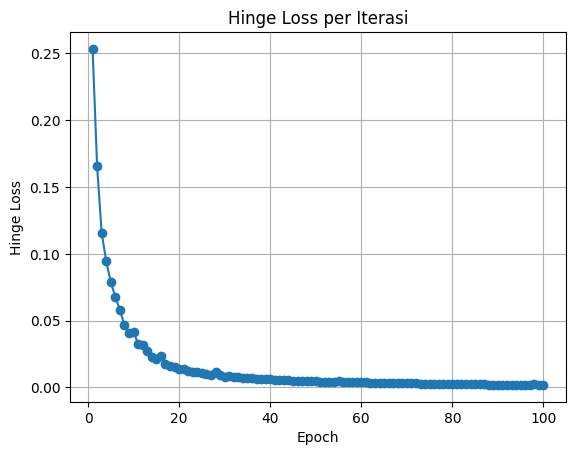

In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, classification_report, hinge_loss
import matplotlib.pyplot as plt
import numpy as np

# Inisialisasi model SVM dengan SGD
svm_iter = SGDClassifier(loss='hinge', learning_rate='constant', eta0=0.001, max_iter=1, warm_start=True, random_state=42)

# Track loss
loss_history = []
epochs = 100

# Partial fit butuh tau dulu kelasnya
classes = np.unique(y_train)

for epoch in range(epochs):
    # Training 1 iterasi
    svm_iter.partial_fit(Xcount_train_transformed, y_train, classes=classes)

    # Predict decision function (jarak ke hyperplane)
    decision_values = svm_iter.decision_function(Xcount_train_transformed)

    # Hitung hinge loss
    loss = hinge_loss(y_train, decision_values)
    loss_history.append(loss)

# Prediksi hasil akhir
y_pred_iter = svm_iter.predict(Xcount_test_transformed)

# Evaluasi
print('Accuracy Score: {0:0.4f}'.format(accuracy_score(y_test, y_pred_iter)))
print(f"Classification Report:\n{classification_report(y_test, y_pred_iter)}")

# Plot loss per iterasi
plt.plot(range(1, epochs+1), loss_history, marker='o')
plt.title('Hinge Loss per Iterasi')
plt.xlabel('Epoch')
plt.ylabel('Hinge Loss')
plt.grid(True)
plt.show()


In [ ]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler with with_mean=False
scaler = StandardScaler(with_mean=False)

# Scale the training and test data
X_train_scaled_ngr = scaler.fit_transform(Xcount_train_transformed_ngr)
X_test_scaled_ngr = scaler.transform(Xcount_test_transformed_ngr)


In [ ]:
# n gram bag of words
from sklearn.svm import SVC

svc=SVC()
svc.fit(X_train_scaled_ngr, y_train)

# Prediksi
y_pred=svc.predict(X_test_scaled_ngr)

# Menghitung akurasi dan metrik evaluasi
print('Accuracy Score: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))
print(f"Classification Report:\n{classification_report(y_test, y_pred)}")

Accuracy Score: 0.6805
Classification Report:
              precision    recall  f1-score   support

        fake       0.61      0.96      0.75       259
        real       0.91      0.41      0.57       270

    accuracy                           0.68       529
   macro avg       0.76      0.69      0.66       529
weighted avg       0.76      0.68      0.66       529



In [ ]:
# bag of words Default
from sklearn.svm import SVC

svc=SVC()
svc.fit(Xcount_train_transformed_ngr, y_train)

# Prediksi
y_pred=svc.predict(Xcount_test_transformed_ngr)

# Menghitung akurasi dan metrik evaluasi
print('Accuracy Score: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))
print(f"Classification Report:\n{classification_report(y_test, y_pred)}")

Accuracy Score: 0.8129
Classification Report:
              precision    recall  f1-score   support

        fake       0.74      0.95      0.83       259
        real       0.93      0.68      0.79       270

    accuracy                           0.81       529
   macro avg       0.84      0.82      0.81       529
weighted avg       0.84      0.81      0.81       529



Accuracy Score: 0.9168
Classification Report:
              precision    recall  f1-score   support

        fake       0.92      0.90      0.91       259
        real       0.91      0.93      0.92       270

    accuracy                           0.92       529
   macro avg       0.92      0.92      0.92       529
weighted avg       0.92      0.92      0.92       529



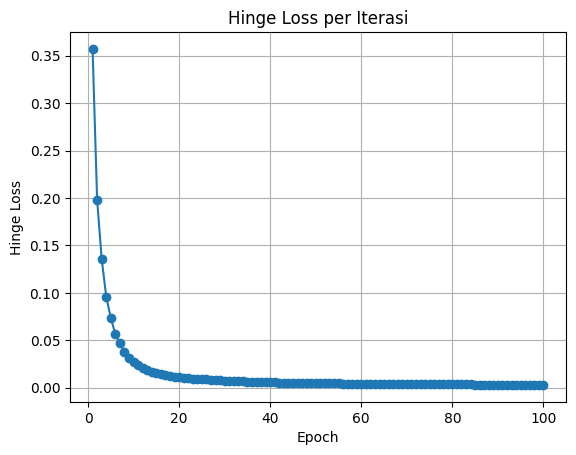

In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, classification_report, hinge_loss
import matplotlib.pyplot as plt
import numpy as np

# Inisialisasi model SVM dengan SGD
svm_iter = SGDClassifier(loss='hinge', learning_rate='constant', eta0=0.001, max_iter=1, warm_start=True, random_state=42)

# Track loss
loss_history = []
epochs = 100

# Partial fit butuh tau dulu kelasnya
classes = np.unique(y_train)

for epoch in range(epochs):
    # Training 1 iterasi
    svm_iter.partial_fit(Xcount_train_transformed_ngr, y_train, classes=classes)

    # Predict decision function (jarak ke hyperplane)
    decision_values = svm_iter.decision_function(Xcount_train_transformed_ngr)

    # Hitung hinge loss
    loss = hinge_loss(y_train, decision_values)
    loss_history.append(loss)

# Prediksi hasil akhir
y_pred_iter = svm_iter.predict(Xcount_test_transformed_ngr)

# Evaluasi
print('Accuracy Score: {0:0.4f}'.format(accuracy_score(y_test, y_pred_iter)))
print(f"Classification Report:\n{classification_report(y_test, y_pred_iter)}")

# Plot loss per iterasi
plt.plot(range(1, epochs+1), loss_history, marker='o')
plt.title('Hinge Loss per Iterasi')
plt.xlabel('Epoch')
plt.ylabel('Hinge Loss')
plt.grid(True)
plt.show()


## K Nearest Neighbor

In [ ]:
# Import KNeighborsClassifier
from sklearn.neighbors import KNeighborsClassifier
max = 0.5
for i in range(3,11,2):
  # Initialize the k-NN model (default k=5)
  knn = KNeighborsClassifier(n_neighbors=i)

  # Train the model
  knn.fit(X_train_transformed, y_train)

  # Make predictions
  y_pred = knn.predict(X_test_transformed)
  report = classification_report(y_test, y_pred, output_dict=True)
  if report['fake']['recall'] > max:
    max = report['fake']['recall']
    pred_opt = y_pred
    neighbors = i


# Calculate accuracy and evaluation metrics
print('Accuracy Score: {0:0.4f}'.format(accuracy_score(y_test, pred_opt)))
print(f"Classification Report:\n{classification_report(y_test, pred_opt)}")
print(neighbors)

Accuracy Score: 0.8847
Classification Report:
              precision    recall  f1-score   support

        fake       0.84      0.94      0.89       259
        real       0.93      0.83      0.88       270

    accuracy                           0.88       529
   macro avg       0.89      0.89      0.88       529
weighted avg       0.89      0.88      0.88       529

5


In [ ]:
# Import KNeighborsClassifier
from sklearn.neighbors import KNeighborsClassifier
max = 0.5
for i in range(3,11,2):
  for j in range(5,100,5):
    # Initialize the k-NN model (default k=5)
    knn = KNeighborsClassifier(n_neighbors=i)

    # Train the model
    knn.fit(X_train_transformed, y_train)

    # Make predictions
    y_pred = knn.predict(X_test_transformed)
    report = classification_report(y_test, y_pred, output_dict=True)
    if report['fake']['recall'] > max:
      max = report['fake']['recall']
      features = j/100*X_train_transformed.shape[1]
      pred_opt = y_pred
      neighbors = i


# Calculate accuracy and evaluation metrics
print('Accuracy Score: {0:0.4f}'.format(accuracy_score(y_test, pred_opt)))
print(f"Classification Report:\n{classification_report(y_test, pred_opt)}")
print(neighbors)
print(features)

Accuracy Score: 0.8847
Classification Report:
              precision    recall  f1-score   support

        fake       0.84      0.94      0.89       259
        real       0.93      0.83      0.88       270

    accuracy                           0.88       529
   macro avg       0.89      0.89      0.88       529
weighted avg       0.89      0.88      0.88       529

5
1018.75


In [ ]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler with with_mean=False
scaler = StandardScaler(with_mean=False)

# Scale the training and test data
X_train_scaled = scaler.fit_transform(Xcount_train_transformed)
X_test_scaled = scaler.transform(Xcount_test_transformed)


In [ ]:
# Import KNeighborsClassifier
from sklearn.neighbors import KNeighborsClassifier
max = 0.5
for i in range(3,11,2):
  # Initialize the k-NN model (default k=5)
  knn = KNeighborsClassifier(n_neighbors=i)

  # Train the model
  knn.fit(X_train_scaled, y_train)

  # Make predictions
  y_pred = knn.predict(X_test_scaled)
  report = classification_report(y_test, y_pred, output_dict=True)
  if report['fake']['recall'] > max:
    max = report['fake']['recall']
    pred_opt = y_pred
    neighbors = i


# Calculate accuracy and evaluation metrics
print('Accuracy Score: {0:0.4f}'.format(accuracy_score(y_test, pred_opt)))
print(f"Classification Report:\n{classification_report(y_test, pred_opt)}")
print(neighbors)

Accuracy Score: 0.5766
Classification Report:
              precision    recall  f1-score   support

        fake       0.54      1.00      0.70       259
        real       1.00      0.17      0.29       270

    accuracy                           0.58       529
   macro avg       0.77      0.59      0.49       529
weighted avg       0.77      0.58      0.49       529

3


In [ ]:
# Import KNeighborsClassifier
from sklearn.neighbors import KNeighborsClassifier
max = 0.5
for i in range(3,11,2):
  # Initialize the k-NN model (default k=5)
  knn = KNeighborsClassifier(n_neighbors=i)

  # Train the model
  knn.fit(Xcount_train_transformed, y_train)

  # Make predictions
  y_pred = knn.predict(Xcount_test_transformed)
  report = classification_report(y_test, y_pred, output_dict=True)
  if report['fake']['recall'] > max:
    max = report['fake']['recall']
    pred_opt = y_pred
    neighbors = i


# Calculate accuracy and evaluation metrics
print('Accuracy Score: {0:0.4f}'.format(accuracy_score(y_test, pred_opt)))
print(f"Classification Report:\n{classification_report(y_test, pred_opt)}")
print(neighbors)

Accuracy Score: 0.6767
Classification Report:
              precision    recall  f1-score   support

        fake       0.61      0.98      0.75       259
        real       0.95      0.39      0.55       270

    accuracy                           0.68       529
   macro avg       0.78      0.68      0.65       529
weighted avg       0.78      0.68      0.65       529

3


In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(with_mean=False)
X_train_scaled_ngr = scaler.fit_transform(Xcount_train_transformed_ngr)
X_test_scaled_ngr = scaler.transform(Xcount_test_transformed_ngr)

In [ ]:
# Import KNeighborsClassifier
from sklearn.neighbors import KNeighborsClassifier
max = 0.5
for i in range(3,11,2):
  # Initialize the k-NN model (default k=5)
  knn = KNeighborsClassifier(n_neighbors=i)

  # Train the model
  knn.fit(X_train_scaled_ngr, y_train)

  # Make predictions
  y_pred = knn.predict(X_test_scaled_ngr)
  report = classification_report(y_test, y_pred, output_dict=True)
  if report['fake']['recall'] > max:
    max = report['fake']['recall']
    pred_opt = y_pred
    neighbors = i


# Calculate accuracy and evaluation metrics
print('Accuracy Score: {0:0.4f}'.format(accuracy_score(y_test, pred_opt)))
print(f"Classification Report:\n{classification_report(y_test, pred_opt)}")
print(neighbors)

Accuracy Score: 0.5860
Classification Report:
              precision    recall  f1-score   support

        fake       0.54      1.00      0.70       259
        real       1.00      0.19      0.32       270

    accuracy                           0.59       529
   macro avg       0.77      0.59      0.51       529
weighted avg       0.78      0.59      0.51       529

3


In [ ]:
# Import KNeighborsClassifier
from sklearn.neighbors import KNeighborsClassifier
max = 0.5
for i in range(3,11,2):
  # Initialize the k-NN model (default k=5)
  knn = KNeighborsClassifier(n_neighbors=i)

  # Train the model
  knn.fit(Xcount_train_transformed_ngr, y_train)

  # Make predictions
  y_pred = knn.predict(Xcount_test_transformed_ngr)
  report = classification_report(y_test, y_pred, output_dict=True)
  if report['fake']['recall'] > max:
    max = report['fake']['recall']
    pred_opt = y_pred
    neighbors = i


# Calculate accuracy and evaluation metrics
print('Accuracy Score: {0:0.4f}'.format(accuracy_score(y_test, pred_opt)))
print(f"Classification Report:\n{classification_report(y_test, pred_opt)}")
print(neighbors)

Accuracy Score: 0.5841
Classification Report:
              precision    recall  f1-score   support

        fake       0.54      1.00      0.70       259
        real       1.00      0.19      0.31       270

    accuracy                           0.58       529
   macro avg       0.77      0.59      0.51       529
weighted avg       0.78      0.58      0.50       529

3


## Tree-Based Model

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report


## Decision Tree

In [ ]:
# TF IDF Default
# Random Forest
dt = DecisionTreeClassifier()
dt.fit(X_train_transformed, y_train)

# Predict with Random Forest
y_pred_dt = dt.predict(X_test_transformed)
print('Decision Tree - Accuracy Score: {0:0.4f}'.format(accuracy_score(y_test, y_pred_dt)))
print(f"Decision Tree - Classification Report:\n{classification_report(y_test, y_pred_dt)}")

Decision Tree - Accuracy Score: 0.8129
Decision Tree - Classification Report:
              precision    recall  f1-score   support

        fake       0.80      0.83      0.81       259
        real       0.83      0.80      0.81       270

    accuracy                           0.81       529
   macro avg       0.81      0.81      0.81       529
weighted avg       0.81      0.81      0.81       529



In [ ]:
# Limited tf idf
# Train the model
max = 0.5

for i in range(5,100,5):
  vectorizer_limited = TfidfVectorizer(max_features=int(i/100*X_train_transformed.shape[1]//1))
  X_train_transformed_limited = vectorizer_limited.fit_transform(X_train)
  X_test_transformed_limited = vectorizer_limited.transform(X_test)

  dt.fit(X_train_transformed_limited, y_train)

  # Predict on the test set
  y_pred = dt.predict(X_test_transformed_limited)
  report = classification_report(y_test, y_pred, output_dict=True)
  if report['fake']['recall'] > max:
    max = report['fake']['recall']
    features = i/100*X_train_transformed.shape[1]
    pred_opt = y_pred
    maxf = int(i/100*X_train_transformed.shape[1]//1)

# Print the accuracy and classification report
print(f"Accuracy: {accuracy_score(y_test, pred_opt)}")
print(f"Classification Report:\n{classification_report(y_test, pred_opt)}")
print(maxf)

Accuracy: 0.8412098298676749
Classification Report:
              precision    recall  f1-score   support

        fake       0.83      0.85      0.84       259
        real       0.85      0.83      0.84       270

    accuracy                           0.84       529
   macro avg       0.84      0.84      0.84       529
weighted avg       0.84      0.84      0.84       529

3056


In [ ]:
# n gram
# Random Forest
dt = DecisionTreeClassifier()
dt.fit(Xcount_train_transformed, y_train)

# Predict with Random Forest
y_pred_dt = dt.predict(Xcount_test_transformed)
print('Decision Tree - Accuracy Score: {0:0.4f}'.format(accuracy_score(y_test, y_pred_dt)))
print(f"Decision Tree - Classification Report:\n{classification_report(y_test, y_pred_dt)}")

Decision Tree - Accuracy Score: 0.7977
Decision Tree - Classification Report:
              precision    recall  f1-score   support

        fake       0.78      0.82      0.80       259
        real       0.82      0.78      0.80       270

    accuracy                           0.80       529
   macro avg       0.80      0.80      0.80       529
weighted avg       0.80      0.80      0.80       529



In [ ]:
# Decision Tree
dt = DecisionTreeClassifier()
dt.fit(Xcount_train_transformed_ngr, y_train)

# Predict with Decision Tree
y_pred_dt = dt.predict(Xcount_test_transformed_ngr)
print('Decision Tree - Accuracy Score: {0:0.4f}'.format(accuracy_score(y_test, y_pred_dt)))
print(f"Decision Tree - Classification Report:\n{classification_report(y_test, y_pred_dt)}")

Decision Tree - Accuracy Score: 0.8828
Decision Tree - Classification Report:
              precision    recall  f1-score   support

        fake       0.92      0.84      0.88       259
        real       0.86      0.93      0.89       270

    accuracy                           0.88       529
   macro avg       0.89      0.88      0.88       529
weighted avg       0.89      0.88      0.88       529



In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, learning_curve
dt = DecisionTreeClassifier()

param_grid = {
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'criterion': ['gini', 'entropy']
}

grid_search = GridSearchCV(dt, param_grid, cv=5, scoring='accuracy')
grid_search.fit(Xcount_train_transformed_ngr, y_train)

best_dt = grid_search.best_estimator_
y_pred = best_dt.predict(Xcount_test_transformed_ngr)

print(f"Best Parameters: {grid_search.best_params_}")
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Decision Tree - Classification Report:\n{classification_report(y_test, y_pred)}")

Best Parameters: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10}
Accuracy: 0.8733459357277883
Decision Tree - Classification Report:
              precision    recall  f1-score   support

        fake       0.89      0.85      0.87       259
        real       0.86      0.90      0.88       270

    accuracy                           0.87       529
   macro avg       0.87      0.87      0.87       529
weighted avg       0.87      0.87      0.87       529



In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, recall_score
import numpy as np

# Predictions
y_train_pred = dt.predict(Xcount_train_transformed_ngr)
y_test_pred = dt.predict(Xcount_test_transformed_ngr)

# Evaluate accuracy on training and test sets
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print(f"Training Accuracy: {train_acc:.4f}")
print(f"Testing Accuracy: {test_acc:.4f}")
#crossval
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(dt, Xcount_train_transformed_ngr, y_train, cv=cv)

mean_cv_score = np.mean(cv_scores)
std_cv_score = np.std(cv_scores)

#threshold overfit
threshold = mean_cv_score - 2 * std_cv_score

print(f"Cross-validation Mean Score: {mean_cv_score:.4f}")
print(f"Cross-validation Score Std Dev: {std_cv_score:.4f}")
print(f"Threshold for Overfitting Detection: {threshold:.4f}")

# Check for overfitting
if test_acc < threshold:
    print("Potential overfitting detected!")
else:
    print("Model generalizes well.")

Training Accuracy: 1.0000
Testing Accuracy: 0.8960
Cross-validation Mean Score: 0.8450
Cross-validation Score Std Dev: 0.0121
Threshold for Overfitting Detection: 0.8208
Model generalizes well.


In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, recall_score
import numpy as np

#Stratified K-Fold to Randomize the Data
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

#Predictions
y_train_pred = dt.predict(Xcount_train_transformed_ngr)
y_test_pred = dt.predict(Xcount_test_transformed_ngr)

#Evaluate accuracy
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print(f"Training Accuracy: {train_acc:.4f}")
print(f"Testing Accuracy: {test_acc:.4f}")

#Manually perform cross-validation with recall scoring
cv_scores = []

for train_idx, val_idx in cv.split(Xcount_train_transformed_ngr, y_train):
    X_fold_train, X_fold_val = Xcount_train_transformed_ngr[train_idx], Xcount_train_transformed_ngr[val_idx]
    y_fold_train, y_fold_val = y_train[train_idx], y_train[val_idx]

    #Train the classifier on this fold
    dt.fit(X_fold_train, y_fold_train)

    #Predict on the validation fold
    y_fold_pred = dt.predict(X_fold_val)

    #Calculate recall
    recall = recall_score(y_fold_val, y_fold_pred, average="macro", zero_division=1)
    cv_scores.append(recall)

    # # Debugging: Check unique labels predicted
    # print(f"Fold {len(cv_scores)} - Unique Predictions: {np.unique(y_fold_pred)}")

cv_scores = np.array(cv_scores)

#Calculate mean and standard deviation
mean_cv_score = np.mean(cv_scores)
std_cv_score = np.std(cv_scores)

#Threshold for overfitting detection
threshold = mean_cv_score - 2 * std_cv_score #Normal assumption

print(f"Cross-validation Recall Scores: {cv_scores}")
print(f"Cross-validation Mean Recall: {mean_cv_score:.4f}")
print(f"Cross-validation Recall Std Dev: {std_cv_score:.4f}")
print(f"Threshold for Overfitting Detection: {threshold:.4f}")

#Check for overfitting
if test_acc < threshold:
    print("Potential overfitting detected!")
else:
    print("Model generalizes well.")


Training Accuracy: 1.0000
Testing Accuracy: 0.8960
Cross-validation Recall Scores: [0.83353018 0.86548556 0.85337302 0.85238095 0.82094885]
Cross-validation Mean Recall: 0.8451
Cross-validation Recall Std Dev: 0.0158
Threshold for Overfitting Detection: 0.8135
Model generalizes well.


## Random Forest

In [ ]:
# TF IDF Default
# Random Forest
rf = RandomForestClassifier()
rf.fit(X_train_transformed, y_train)

# Predict with Random Forest
y_pred_rf = rf.predict(X_test_transformed)
print('Random Forest - Accuracy Score: {0:0.4f}'.format(accuracy_score(y_test, y_pred_rf)))
print(f"Random Forest - Classification Report:\n{classification_report(y_test, y_pred_rf)}")

Random Forest - Accuracy Score: 0.9093
Random Forest - Classification Report:
              precision    recall  f1-score   support

        fake       0.92      0.90      0.91       267
        real       0.90      0.92      0.91       262

    accuracy                           0.91       529
   macro avg       0.91      0.91      0.91       529
weighted avg       0.91      0.91      0.91       529



In [ ]:
# Limited tf idf
# Train the model
max = 0.5

for i in range(5,100,5):
  vectorizer_limited = TfidfVectorizer(max_features=int(i/100*X_train_transformed.shape[1]//1))
  X_train_transformed_limited = vectorizer_limited.fit_transform(X_train)
  X_test_transformed_limited = vectorizer_limited.transform(X_test)

  rf.fit(X_train_transformed_limited, y_train)

  # Predict on the test set
  y_pred = rf.predict(X_test_transformed_limited)
  report = classification_report(y_test, y_pred, output_dict=True)
  if report['fake']['recall'] > max:
    max = report['fake']['recall']
    features = i/100*X_train_transformed.shape[1]
    pred_opt = y_pred
    maxf = int(i/100*X_train_transformed.shape[1]//1)

# Print the accuracy and classification report
print(f"Accuracy: {accuracy_score(y_test, pred_opt)}")
print(f"Classification Report:\n{classification_report(y_test, pred_opt)}")
print(maxf)

Accuracy: 0.9224952741020794
Classification Report:
              precision    recall  f1-score   support

        fake       0.93      0.91      0.92       267
        real       0.91      0.94      0.92       262

    accuracy                           0.92       529
   macro avg       0.92      0.92      0.92       529
weighted avg       0.92      0.92      0.92       529

6140


In [ ]:
# n gram
# Random Forest
rf = RandomForestClassifier()
rf.fit(Xcount_train_transformed, y_train)

# Predict with Random Forest
y_pred_rf = rf.predict(Xcount_test_transformed)
print('Random Forest - Accuracy Score: {0:0.4f}'.format(accuracy_score(y_test, y_pred_rf)))
print(f"Random Forest - Classification Report:\n{classification_report(y_test, y_pred_rf)}")

Random Forest - Accuracy Score: 0.9017
Random Forest - Classification Report:
              precision    recall  f1-score   support

        fake       0.93      0.87      0.90       267
        real       0.88      0.94      0.90       262

    accuracy                           0.90       529
   macro avg       0.90      0.90      0.90       529
weighted avg       0.90      0.90      0.90       529



In [ ]:
# n gram bag of words
# Random Forest
rf = RandomForestClassifier()
rf.fit(Xcount_train_transformed_ngr, y_train)

# Predict with Random Forest
y_pred_rf = rf.predict(Xcount_test_transformed_ngr)
print('Random Forest - Accuracy Score: {0:0.4f}'.format(accuracy_score(y_test, y_pred_rf)))
print(f"Random Forest - Classification Report:\n{classification_report(y_test, y_pred_rf)}")


Random Forest - Accuracy Score: 0.9036
Random Forest - Classification Report:
              precision    recall  f1-score   support

        fake       0.98      0.82      0.90       267
        real       0.85      0.98      0.91       262

    accuracy                           0.90       529
   macro avg       0.91      0.90      0.90       529
weighted avg       0.91      0.90      0.90       529



In [ ]:
from sklearn.model_selection import cross_val_score
import numpy as np

# Predictions
y_train_pred = rf.predict(Xcount_train_transformed_ngr)
y_test_pred = rf.predict(Xcount_test_transformed_ngr)

# Evaluate accuracy on training and test sets
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print(f"Training Accuracy: {train_acc:.4f}")
print(f"Testing Accuracy: {test_acc:.4f}")
#crossval
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(rf, Xcount_train_transformed_ngr, y_train, cv=cv)

mean_cv_score = np.mean(cv_scores)
std_cv_score = np.std(cv_scores)

#threshold overfit
threshold = mean_cv_score - 2 * std_cv_score

print(f"Cross-validation Mean Score: {mean_cv_score:.4f}")
print(f"Cross-validation Score Std Dev: {std_cv_score:.4f}")
print(f"Threshold for Overfitting Detection: {threshold:.4f}")

# Check for overfitting
if test_acc < threshold:
    print("Potential overfitting detected!")
else:
    print("Model generalizes well.")

Training Accuracy: 1.0000
Testing Accuracy: 0.9036
Cross-validation Mean Score: 0.8985
Cross-validation Score Std Dev: 0.0107
Threshold for Overfitting Detection: 0.8770
Model generalizes well.


In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, recall_score
import numpy as np

#Stratified K-Fold to Randomize the Data
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

#Predictions
y_train_pred = rf.predict(Xcount_train_transformed_ngr)
y_test_pred = rf.predict(Xcount_test_transformed_ngr)

#Evaluate accuracy
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print(f"Training Accuracy: {train_acc:.4f}")
print(f"Testing Accuracy: {test_acc:.4f}")

#Manually perform cross-validation with recall scoring
cv_scores = []

for train_idx, val_idx in cv.split(Xcount_train_transformed_ngr, y_train):
    X_fold_train, X_fold_val = Xcount_train_transformed_ngr[train_idx], Xcount_train_transformed_ngr[val_idx]
    y_fold_train, y_fold_val = y_train[train_idx], y_train[val_idx]

    #Train the classifier on this fold
    rf.fit(X_fold_train, y_fold_train)

    #Predict on the validation fold
    y_fold_pred = rf.predict(X_fold_val)

    #Calculate recall
    recall = recall_score(y_fold_val, y_fold_pred, average="macro", zero_division=1)
    cv_scores.append(recall)

    # # Debugging: Check unique labels predicted
    # print(f"Fold {len(cv_scores)} - Unique Predictions: {np.unique(y_fold_pred)}")

cv_scores = np.array(cv_scores)

#Calculate mean and standard deviation
mean_cv_score = np.mean(cv_scores)
std_cv_score = np.std(cv_scores)

#Threshold for overfitting detection
threshold = mean_cv_score - 2 * std_cv_score #Normal assumption

print(f"Cross-validation Recall Scores: {cv_scores}")
print(f"Cross-validation Mean Recall: {mean_cv_score:.4f}")
print(f"Cross-validation Recall Std Dev: {std_cv_score:.4f}")
print(f"Threshold for Overfitting Detection: {threshold:.4f}")

#Check for overfitting
if test_acc < threshold:
    print("Potential overfitting detected!")
else:
    print("Model generalizes well.")


Training Accuracy: 1.0000
Testing Accuracy: 0.9036
Cross-validation Recall Scores: [0.90091864 0.91387795 0.90456349 0.87519841 0.90154172]
Cross-validation Mean Recall: 0.8992
Cross-validation Recall Std Dev: 0.0129
Threshold for Overfitting Detection: 0.8735
Model generalizes well.


## XGBoost

In [ ]:
# TF IDF Default
# XGBoost
from sklearn.preprocessing import LabelEncoder

# Create a LabelEncoder object
le = LabelEncoder()

# Fit the encoder to your training target variable (y_train)
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)
xgb = XGBClassifier(eval_metric='mlogloss')  # Ensure eval_metric is set to avoid warnings
xgb.fit(X_train_transformed, y_train)
# Predict with XGBoost
y_pred_xgb = xgb.predict(X_test_transformed)
print('XGBoost - Accuracy Score: {0:0.4f}'.format(accuracy_score(y_test, y_pred_xgb)))
print(f"XGBoost - Classification Report:\n{classification_report(y_test, y_pred_xgb)}")

XGBoost - Accuracy Score: 0.9036
XGBoost - Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.90      0.90       267
           1       0.90      0.91      0.90       262

    accuracy                           0.90       529
   macro avg       0.90      0.90      0.90       529
weighted avg       0.90      0.90      0.90       529



In [ ]:
# Limited tf idf
# Train the model
max = 0.5

for i in range(5,100,5):
  vectorizer_limited = TfidfVectorizer(max_features=int(i/100*X_train_transformed.shape[1]//1))
  X_train_transformed_limited = vectorizer_limited.fit_transform(X_train)
  X_test_transformed_limited = vectorizer_limited.transform(X_test)

  xgb.fit(X_train_transformed_limited, y_train)

  # Predict on the test set
  y_pred = xgb.predict(X_test_transformed_limited)
  report = classification_report(y_test, y_pred, output_dict=True)
  if report['0']['recall'] > max:
    max = report['0']['recall']
    features = i/100*X_train_transformed.shape[1]
    pred_opt = y_pred
    maxf = int(i/100*X_train_transformed.shape[1]//1)

# Print the accuracy and classification report
print(f"Accuracy: {accuracy_score(y_test, pred_opt)}")
print(f"Classification Report:\n{classification_report(y_test, pred_opt)}")
print(maxf)

Accuracy: 0.9187145557655955
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.92      0.92       267
           1       0.92      0.92      0.92       262

    accuracy                           0.92       529
   macro avg       0.92      0.92      0.92       529
weighted avg       0.92      0.92      0.92       529

9211


In [ ]:
# XGBoost
# n gram
from sklearn.preprocessing import LabelEncoder

# Create a LabelEncoder object
le = LabelEncoder()

# Fit the encoder to your training target variable (y_train)
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)
xgb = XGBClassifier(eval_metric='mlogloss')  # Ensure eval_metric is set to avoid warnings
xgb.fit(X_train_scaled, y_train)

# Predict with XGBoost
y_pred_xgb = xgb.predict(X_test_scaled)
print('XGBoost - Accuracy Score: {0:0.4f}'.format(accuracy_score(y_test, y_pred_xgb)))
print(f"XGBoost - Classification Report:\n{classification_report(y_test, y_pred_xgb)}")

XGBoost - Accuracy Score: 0.9093
XGBoost - Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.89      0.91       267
           1       0.89      0.93      0.91       262

    accuracy                           0.91       529
   macro avg       0.91      0.91      0.91       529
weighted avg       0.91      0.91      0.91       529



In [ ]:
# XGBoost
# n gram bag of words
from sklearn.preprocessing import LabelEncoder

# Create a LabelEncoder object
le = LabelEncoder()

# Fit the encoder to your training target variable (y_train)
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)
xgb = XGBClassifier(eval_metric='mlogloss')  # Ensure eval_metric is set to avoid warnings
xgb.fit(X_train_scaled_ngr, y_train)

# Predict with XGBoost
y_pred_xgb = xgb.predict(X_test_scaled_ngr)
print('XGBoost - Accuracy Score: {0:0.4f}'.format(accuracy_score(y_test, y_pred_xgb)))
print(f"XGBoost - Classification Report:\n{classification_report(y_test, y_pred_xgb)}")

XGBoost - Accuracy Score: 0.8941
XGBoost - Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.85      0.89       267
           1       0.86      0.94      0.90       262

    accuracy                           0.89       529
   macro avg       0.90      0.89      0.89       529
weighted avg       0.90      0.89      0.89       529



In [ ]:
# Predictions
y_train_pred = xgb.predict(X_train_scaled_ngr)
y_test_pred = xgb.predict(X_test_scaled_ngr)

# Evaluate accuracy on training and test sets
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print(f"Training Accuracy: {train_acc:.4f}")
print(f"Testing Accuracy: {test_acc:.4f}")
#crossval
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(xgb, X_train_scaled_ngr, y_train, cv=cv)

mean_cv_score = np.mean(cv_scores)
std_cv_score = np.std(cv_scores)

#threshold overfit
threshold = mean_cv_score - 2 * std_cv_score

print(f"Cross-validation Mean Score: {mean_cv_score:.4f}")
print(f"Cross-validation Score Std Dev: {std_cv_score:.4f}")
print(f"Threshold for Overfitting Detection: {threshold:.4f}")

# Check for overfitting
if test_acc < threshold:
    print("Potential overfitting detected!")
else:
    print("Model generalizes well.")

Training Accuracy: 0.9830
Testing Accuracy: 0.8941
Cross-validation Mean Score: 0.8750
Cross-validation Score Std Dev: 0.0180
Threshold for Overfitting Detection: 0.8390
Model generalizes well.


In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, recall_score
import numpy as np

#Stratified K-Fold to Randomize the Data
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

#Predictions
y_train_pred = xgb.predict(Xcount_train_transformed_ngr)
y_test_pred = xgb.predict(Xcount_test_transformed_ngr)

#Evaluate accuracy
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print(f"Training Accuracy: {train_acc:.4f}")
print(f"Testing Accuracy: {test_acc:.4f}")

#Manually perform cross-validation with recall scoring
cv_scores = []

for train_idx, val_idx in cv.split(Xcount_train_transformed_ngr, y_train):
    X_fold_train, X_fold_val = Xcount_train_transformed_ngr[train_idx], Xcount_train_transformed_ngr[val_idx]
    y_fold_train, y_fold_val = y_train[train_idx], y_train[val_idx]

    #Train the classifier on this fold
    xgb.fit(X_fold_train, y_fold_train)

    #Predict on the validation fold
    y_fold_pred = xgb.predict(X_fold_val)

    #Calculate recall
    recall = recall_score(y_fold_val, y_fold_pred, average="macro", zero_division=1)
    cv_scores.append(recall)

    # # Debugging: Check unique labels predicted
    # print(f"Fold {len(cv_scores)} - Unique Predictions: {np.unique(y_fold_pred)}")

cv_scores = np.array(cv_scores)

#Calculate mean and standard deviation
mean_cv_score = np.mean(cv_scores)
std_cv_score = np.std(cv_scores)

#Threshold for overfitting detection
threshold = mean_cv_score - 2 * std_cv_score #Normal assumption

print(f"Cross-validation Recall Scores: {cv_scores}")
print(f"Cross-validation Mean Recall: {mean_cv_score:.4f}")
print(f"Cross-validation Recall Std Dev: {std_cv_score:.4f}")
print(f"Threshold for Overfitting Detection: {threshold:.4f}")

#Check for overfitting
if test_acc < threshold:
    print("Potential overfitting detected!")
else:
    print("Model generalizes well.")


Training Accuracy: 0.9805
Testing Accuracy: 0.8979
Cross-validation Recall Scores: [0.85738189 0.8589895  0.9015873  0.88888889 0.86531463]
Cross-validation Mean Recall: 0.8744
Cross-validation Recall Std Dev: 0.0177
Threshold for Overfitting Detection: 0.8391
Model generalizes well.


[0]	train-mlogloss:0.60527	eval-mlogloss:0.61042
[1]	train-mlogloss:0.55820	eval-mlogloss:0.55815
[2]	train-mlogloss:0.51516	eval-mlogloss:0.52291
[3]	train-mlogloss:0.47869	eval-mlogloss:0.49675
[4]	train-mlogloss:0.45213	eval-mlogloss:0.47712
[5]	train-mlogloss:0.43022	eval-mlogloss:0.45147
[6]	train-mlogloss:0.41283	eval-mlogloss:0.44038
[7]	train-mlogloss:0.39357	eval-mlogloss:0.42577
[8]	train-mlogloss:0.37895	eval-mlogloss:0.41323
[9]	train-mlogloss:0.36380	eval-mlogloss:0.40170
[10]	train-mlogloss:0.35277	eval-mlogloss:0.39342
[11]	train-mlogloss:0.33864	eval-mlogloss:0.38722
[12]	train-mlogloss:0.32801	eval-mlogloss:0.37671
[13]	train-mlogloss:0.31737	eval-mlogloss:0.36680
[14]	train-mlogloss:0.30868	eval-mlogloss:0.36395
[15]	train-mlogloss:0.29887	eval-mlogloss:0.35635
[16]	train-mlogloss:0.29146	eval-mlogloss:0.35082
[17]	train-mlogloss:0.28456	eval-mlogloss:0.34871
[18]	train-mlogloss:0.27612	eval-mlogloss:0.34248
[19]	train-mlogloss:0.26570	eval-mlogloss:0.33949
[20]	train

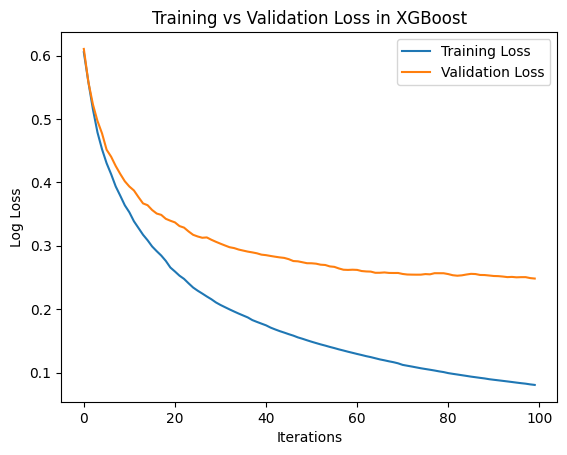

In [ ]:
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report

# Label encoding untuk target (karena XGBoost memerlukan integer labels)
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

# Konversi dataset ke format DMatrix (format khusus untuk XGBoost)
dtrain = xgb.DMatrix(X_train_scaled_ngr, label=y_train_enc)
dtest = xgb.DMatrix(X_test_scaled_ngr, label=y_test_enc)

# Hyperparameter XGBoost
params = {
    'objective': 'multi:softmax',  # Multiclass classification
    'num_class': len(le.classes_),  # Jumlah kelas dalam target
    'eval_metric': 'mlogloss'  # Log loss sebagai metric evaluasi
}

# Variabel untuk menyimpan hasil evaluasi
evals_result = {}

# Training model dengan pemantauan loss
bst = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=100,  # Jumlah iterasi boosting
    evals=[(dtrain, 'train'), (dtest, 'eval')],
    early_stopping_rounds=10,  # Berhenti jika tidak ada peningkatan
    evals_result=evals_result,  # Menyimpan hasil evaluasi
    verbose_eval=True
)

# Plot loss selama training
plt.plot(evals_result['train']['mlogloss'], label='Training Loss')
plt.plot(evals_result['eval']['mlogloss'], label='Validation Loss')
plt.xlabel("Iterations")
plt.ylabel("Log Loss")
plt.title("Training vs Validation Loss in XGBoost")
plt.legend()
plt.show()


In [ ]:
# Make predictions on the test set
y_pred = bst.predict(dtest)

# Convert predicted labels back to original class names (if needed)
y_pred_labels = le.inverse_transform(y_pred.astype(int))
y_test_labels = le.inverse_transform(y_test_enc)

# Print classification report
print(classification_report(y_test_labels, y_pred_labels))
print(accuracy_score(y_test_labels, y_pred_labels))

              precision    recall  f1-score   support

           0       0.92      0.87      0.90       267
           1       0.87      0.93      0.90       262

    accuracy                           0.90       529
   macro avg       0.90      0.90      0.90       529
weighted avg       0.90      0.90      0.90       529

0.8979206049149339
